In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV ,SGDClassifier
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [2]:
print(os.getcwd())
file_path = './datasets/datos_CB.csv'
student_data = pd.read_csv(file_path,index_col=0)
student_data.info()

D:\Guana\Documents\GitHub\academic-predictor
<class 'pandas.core.frame.DataFrame'>
Int64Index: 97341 entries, 401 to 12388
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ciclo         97341 non-null  int64  
 1   Asignatura    97341 non-null  object 
 2   Cod.Car.Sec   97341 non-null  int64  
 3   Convocatoria  97341 non-null  int64  
 4   Anho          97341 non-null  int64  
 5   Aprobado      97341 non-null  int64  
 6   Anho.Firma    97341 non-null  int64  
 7   Primer.Par    97341 non-null  int64  
 8   Segundo.Par   97341 non-null  int64  
 9   AOT           97341 non-null  int64  
 10  Nota.Final    97341 non-null  object 
 11  id_anony      97341 non-null  object 
 12  Nota.Prom     97341 non-null  float64
 13  Firma         97341 non-null  bool   
dtypes: bool(1), float64(1), int64(9), object(3)
memory usage: 10.5+ MB


In [3]:
student_data.head()

,ciclo,Asignatura,Cod.Car.Sec,Convocatoria,Anho,Aprobado,Anho.Firma,Primer.Par,Segundo.Par,AOT,Nota.Final,id_anony,Nota.Prom,Firma
401,1,CALCULO 3,0,1,2012,0,0,0,0,0,[0],es_253,0.0,False
402,1,FISICA 4,1,1,2012,0,2012,19,13,9,[0],es_254,0.0,True
403,1,FISICA 4,0,1,2012,1,2012,17,24,10,[3],es_255,3.0,True
404,1,FISICA 4,1,1,2012,0,0,0,0,0,[0],es_256,0.0,False
405,1,FISICA 4,1,1,2012,0,0,16,12,8,[0],es_257,0.0,False


In [53]:
student_data['Asig.Cod'] = pd.Categorical(student_data['Asignatura'])
student_data['Asig.Cod'] = student_data['Asig.Cod'].cat.codes
student_data['Asig.Cod']

401       4
402      23
403      23
404      23
405      23
         ..
12384    41
12385    41
12386    41
12387    41
12388    41
Name: Asig.Cod, Length: 97341, dtype: int8

In [4]:
def get_course(student_data,course):
    condition = student_data["Asignatura"] == course
    course_data = student_data[condition]
    course_data.drop(["Nota.Prom"],axis=1, inplace = True)
    print("\n",len(course_data))
    course_data.head()
    return course_data

In [5]:
course_data = get_course(student_data,'ESTATICA')
course_data.head()


 4824


C:\Users\Guana\AppData\Local\Temp\ipykernel_24472\1341986020.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  course_data.drop(["Nota.Prom"],axis=1, inplace = True)


,ciclo,Asignatura,Cod.Car.Sec,Convocatoria,Anho,Aprobado,Anho.Firma,Primer.Par,Segundo.Par,AOT,Nota.Final,id_anony,Firma
1744,2,ESTATICA,4,1,2012,0,0,2,13,0,[0],es_469,False
1745,2,ESTATICA,4,1,2012,0,0,6,11,0,[0],es_470,False
1746,2,ESTATICA,3,1,2012,1,2012,12,24,0,[2],es_175,True
1747,2,ESTATICA,3,1,2012,0,0,1,1,0,[0],es_910,False
1748,2,ESTATICA,1,1,2012,0,0,0,0,0,[0],es_1475,False


# Making a new column with number of attemps

In [6]:
def count_attemps(course_data):
    course_data = course_data.sort_values(by=['id_anony','Anho'])
    last_id = course_data['id_anony'].iloc[0]
    counter = 0
    for index,row in course_data.iterrows():
        #print(index)
        if row['id_anony'] == last_id:
            counter += 1 
            course_data.loc[index,['Num.Intento']] = counter
        else:
            last_id = row['id_anony']
            course_data.loc[index,['Num.Intento']] = 1
            counter = 1
    return course_data

In [7]:
course_data = count_attemps(course_data)

# Heat map to check corr

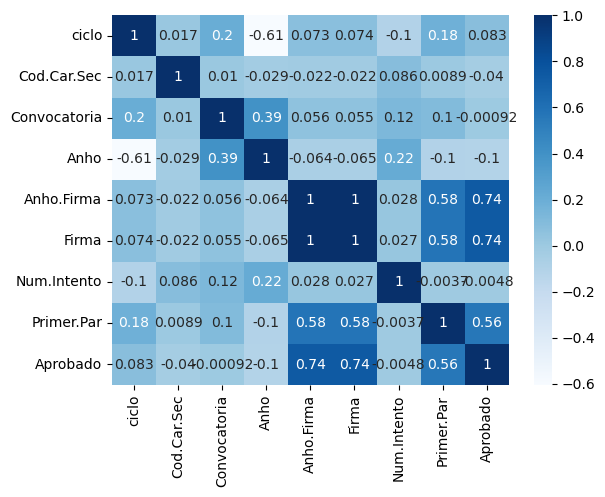

In [58]:
sns.heatmap(course_data[['ciclo','Cod.Car.Sec','Convocatoria','Anho','Anho.Firma','Firma','Num.Intento','Primer.Par','Aprobado']].corr(), cmap='Blues', annot=True)
plt.show()

# Adding previous course data

In [9]:
def get_previous_course(previous_course):
    #slicing
    formated_title = str.title(previous_course.lower().replace(' ', '_'))
    condition = student_data["Asignatura"] == previous_course
    previous_course_data = student_data[condition]
    previous_course_data = count_attemps(previous_course_data)
    previous_course_data = previous_course_data.rename(columns={'Num.Intento':f'Num.Intento.{formated_title}', 'Nota.Prom' : f'Nota.Prom.{formated_title}'})
    previous_course_data = previous_course_data[["id_anony", f'Nota.Prom.{formated_title}', f'Num.Intento.{formated_title}']]
    
    #grouping by id
    attemps = previous_course_data[['id_anony',f'Num.Intento.{formated_title}']].groupby(['id_anony']).max()
    avg_grade = previous_course_data[['id_anony',f'Nota.Prom.{formated_title}']].groupby(['id_anony']).mean()
    result = pd.concat([avg_grade,attemps],axis=1)
    #result
    
    return result

In [10]:
def merge_previous_course(course_data,result):
    result = pd.merge(course_data, result, on = 'id_anony', how = 'left')
    #for col in result.columns:
    #    print(col,np.unique(result[col]))
    return result


In [11]:
def getNans(result):
    course = result.columns[-1][12:] #get the previous course name
    print("Mean grade with NaN:",np.mean(result.iloc[:,-2]),"Mean attemps with NaN:",np.mean(result.iloc[:,-1]))
    result[f'Nota.Prom.{course}'] = result[f'Nota.Prom.{course}'].fillna(result['Primer.Par']/24*5) #averagin from first midterm
    result[f'Num.Intento.{course}'] = result[f'Num.Intento.{course}'].fillna(np.mean(result[f'Num.Intento.{course}']))
    print('Mean grade interpolated',np.mean(result[f'Nota.Prom.{course}']),'Mean attemps interpolated',np.mean(result[f'Num.Intento.{course}']))


In [12]:
def add_course(course_data,previous_course):
    previous_course_data = get_previous_course(previous_course)
    result = merge_previous_course(course_data,previous_course_data)
    getNans(result)
    original = result.copy()
    y = result['Aprobado']
    result.drop(['ciclo','Asignatura','Aprobado','Segundo.Par','AOT','Anho.Firma','Nota.Final','id_anony'],axis=1,inplace = True)
    return result,y,original

In [13]:
result,y,original = add_course(course_data,'ALGEBRA LINEAL 2')

Mean grade with NaN: 1.9052710303304832 Mean attemps with NaN: 1.7153388822829965
Mean grade interpolated 1.8735312360156886 Mean attemps interpolated 1.7153388822829965


In [14]:
result

,Cod.Car.Sec,Convocatoria,Anho,Primer.Par,Firma,Num.Intento,Nota.Prom.Algebra_Lineal_2,Num.Intento.Algebra_Lineal_2
0,5,1,2012,6,False,1.0,1.250000,1.715339
1,5,1,2013,6,True,1.0,1.250000,1.715339
2,5,1,2012,15,True,1.0,3.125000,1.715339
3,1,1,2012,10,True,1.0,2.083333,1.715339
4,1,1,2013,8,True,3.0,1.666667,1.715339
...,...,...,...,...,...,...,...,...
4819,3,1,2012,16,True,1.0,3.333333,1.715339
4820,3,1,2013,0,False,1.0,0.000000,1.715339
4821,5,1,2012,3,False,1.0,0.666667,2.000000
4822,5,1,2013,9,True,2.0,0.666667,2.000000


### Here, it could be useful to repeat this proccess (with a function) and add data for another course like Fisica 1

In [15]:
X_train, X_test, y_train, y_test = train_test_split(result, y, random_state=10)

# Pipeline and Gridsearch

In [16]:
import numpy as np
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import learning_curve

from tempfile import mkdtemp
from shutil import rmtree

In [17]:
def hyperparam_search(x,y):
    std_slc = StandardScaler()
    pca = decomposition.PCA()
    logistic_Reg = linear_model.LogisticRegression(solver='liblinear',max_iter=1000)
    cachedir = mkdtemp()

    pipe = Pipeline(steps = [('scaler', StandardScaler()), ('pca', pca), ('logistic_Reg', logistic_Reg)],memory=cachedir)
    n_components = list(range(1,x.shape[1]+1,1))

    C = np.logspace(-4, 4, 100)
    #C = [0.001, 0.01, 0.1, 1, 10, 100]
    penalty = ['l1', 'l2']

    parameters = [
        {'logistic_Reg__solver' : ['liblinear'],
            'pca__n_components' : n_components,
                          'scaler' : [StandardScaler(), MinMaxScaler()],
                          'logistic_Reg__C' : C,
                          'logistic_Reg__penalty' : penalty[0:2]},
        {'logistic_Reg__solver' : ['newton-cg', 'lbfgs','newton-cholesky'],
            'pca__n_components' : n_components,
                          'scaler' : [StandardScaler(), MinMaxScaler()],
                          'logistic_Reg__C' : C,
                          'logistic_Reg__penalty' : penalty[1:]}
                      ]


    clf_GS = GridSearchCV(pipe, parameters, scoring = 'accuracy', n_jobs=-1)
    clf_GS.fit(x, y)
    
    best_parameters = clf_GS.best_estimator_.get_params()
    for param_name in sorted(parameters[0].keys()):
        print(f"{param_name}: {best_parameters[param_name]}")
    print(f"best score: {clf_GS.best_score_}")
    print(clf_GS.best_estimator_.get_params()['logistic_Reg'])
    
    #print('Best scaler:',clf_GS.best_estimator_.get_params()['scaler'])
    #print('Best Penalty:', clf_GS.best_estimator_.get_params()['logistic_Reg__penalty'])
    #print('Best C:', clf_GS.best_estimator_.get_params()['logistic_Reg__C'])
    #print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
    #print(clf_GS.best_estimator_.get_params()['logistic_Reg'])

# Without tuning

In [39]:
LR = linear_model.LogisticRegression(max_iter = 1000)
LR.fit(X_train,y_train)
LR.score(X_test,y_test)

0.8351824457593688

# With tuning

In [19]:
%store
with warnings.catch_warnings():
    warnings.simplefilter('ignore')    
hyperparam_search(X_train,y_train)

Stored variables and their in-db values:
logistic_Reg__C: 0.002364489412645407
logistic_Reg__penalty: l2
logistic_Reg__solver: liblinear
pca__n_components: 2
scaler: MinMaxScaler()
best score: 0.8662295683271818
LogisticRegression(C=0.002364489412645407, max_iter=1000, solver='liblinear')


# Old parameters attemp

In [20]:
n = 6
scaler = MinMaxScaler()
pca = decomposition.PCA(n_components=n)
logistic_Reg = linear_model.LogisticRegression(C=0.12648552168552957, solver='liblinear', penalty = 'l2')


pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('logistic_Reg', logistic_Reg)])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8756218905472637

In [21]:
#without PCA
scaler = StandardScaler()
logistic_Reg = LogisticRegression(C=0.026560877829466867, max_iter=1000, solver='newton-cg')

pipe = Pipeline(steps=[('scaler', scaler), ('logistic_Reg', logistic_Reg)])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.87893864013267

# Attemp 1

In [50]:
n = 4
scaler = MinMaxScaler()
pca = decomposition.PCA(n_components=n)
logistic_Reg = linear_model.LogisticRegression(C=0.002364489412645407, max_iter=1000, solver='liblinear')

pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('logistic_Reg', logistic_Reg)])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8325115055884287

# Confusion matrix for both

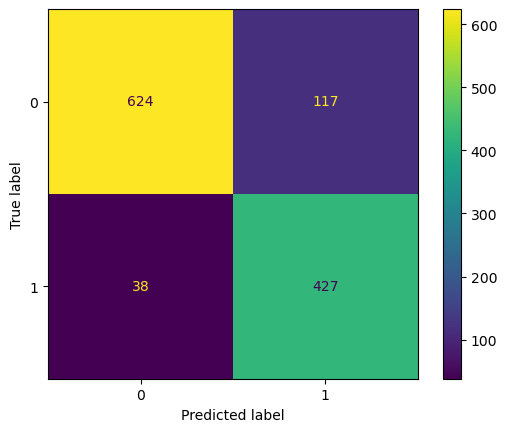

In [23]:
predictions = LR.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=LR.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR.classes_)
disp.plot()
plt.show()

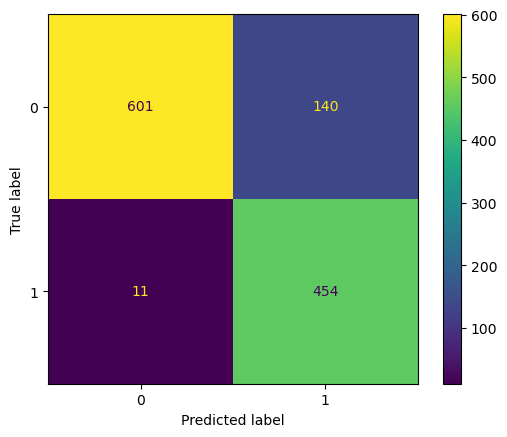

In [24]:
predictions = pipe.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=LR.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR.classes_)
disp.plot()
plt.show()

Maybe changing the threshold could be better

# Learning curve for no tuning and tuned 

Stored variables and their in-db values:


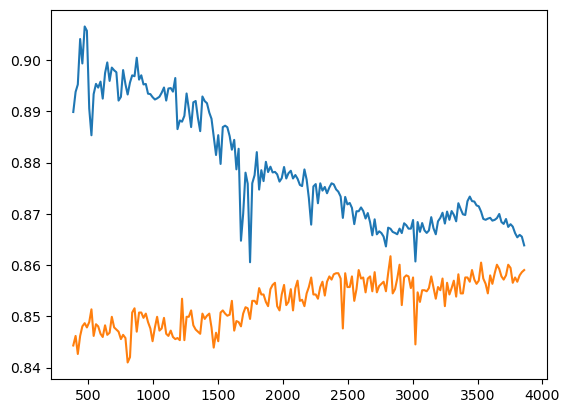

In [25]:
%store
with warnings.catch_warnings():
    warnings.simplefilter('ignore')   
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(LR, result, y, return_times=True, train_sizes=np.linspace(0.1, 1.0, 200))
    plt.plot(train_sizes,np.mean(train_scores,axis=1))
    plt.plot(train_sizes,np.mean(test_scores,axis=1))

Stored variables and their in-db values:


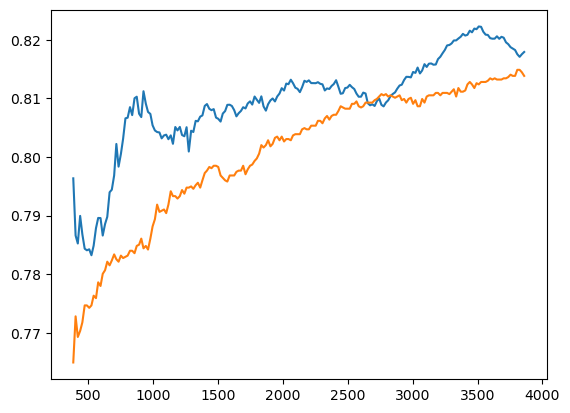

In [26]:
%store
with warnings.catch_warnings():
    warnings.simplefilter('ignore') 
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(logistic_Reg, result, y, return_times=True, train_sizes=np.linspace(0.1, 1.0, 200))
    plt.plot(train_sizes,np.mean(train_scores,axis=1))
    plt.plot(train_sizes,np.mean(test_scores,axis=1))

parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']},
              {'C':[0.001, 0.01, 0.1, 1, 10, 100]}]


# Adding a third course

In [27]:
result,y,original = add_course(original,'FISICA 1')

Mean grade with NaN: 2.791847688610637 Mean attemps with NaN: 1.2760387023335231
Mean grade interpolated 2.501021512806339 Mean attemps interpolated 1.2760387023335231


In [28]:
result

,Cod.Car.Sec,Convocatoria,Anho,Primer.Par,Firma,Num.Intento,Nota.Prom.Algebra_Lineal_2,Num.Intento.Algebra_Lineal_2,Nota.Prom.Fisica_1,Num.Intento.Fisica_1
0,5,1,2012,6,False,1.0,1.250000,1.715339,1.250000,1.276039
1,5,1,2013,6,True,1.0,1.250000,1.715339,1.250000,1.276039
2,5,1,2012,15,True,1.0,3.125000,1.715339,3.125000,1.276039
3,1,1,2012,10,True,1.0,2.083333,1.715339,2.083333,1.276039
4,1,1,2013,8,True,3.0,1.666667,1.715339,1.666667,1.276039
...,...,...,...,...,...,...,...,...,...,...
4819,3,1,2012,16,True,1.0,3.333333,1.715339,3.333333,1.276039
4820,3,1,2013,0,False,1.0,0.000000,1.715339,0.000000,1.276039
4821,5,1,2012,3,False,1.0,0.666667,2.000000,0.625000,1.276039
4822,5,1,2013,9,True,2.0,0.666667,2.000000,1.875000,1.276039


In [29]:
X_train, X_test, y_train, y_test = train_test_split(result, y, random_state=10)

%%script false

In [30]:
LR = linear_model.LogisticRegression(max_iter=1000)
LR.fit(X_train,y_train)
LR.score(X_test,y_test)

0.87893864013267

In [31]:
hyperparam_search(X_train,y_train)

logistic_Reg__C: 0.06734150657750829
logistic_Reg__penalty: l1
logistic_Reg__solver: liblinear
pca__n_components: 10
scaler: StandardScaler()
best score: 0.8642920458800425
LogisticRegression(C=0.06734150657750829, max_iter=1000, penalty='l1',
                   solver='liblinear')


In [32]:
n = 7
scaler = MinMaxScaler()
pca = decomposition.PCA(n_components=n)
logistic_Reg = linear_model.LogisticRegression(C=4.862601580065354, max_iter=1000, penalty='l1',
                   solver='liblinear')

pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('logistic_Reg', logistic_Reg)])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.87893864013267

# Comparing with a general dataset (without splitting into courses)

In [33]:
student_data
y = student_data['Aprobado']
x = student_data.drop(['Asignatura','Segundo.Par','AOT','Nota.Final','id_anony','Nota.Prom','Aprobado'],axis=1)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=10)

In [35]:
hyperparam_search(X_train,y_train)

logistic_Reg__C: 4750.810162102803
logistic_Reg__penalty: l1
logistic_Reg__solver: liblinear
pca__n_components: 7
scaler: MinMaxScaler()
best score: 0.8472981302650503
LogisticRegression(C=4750.810162102803, max_iter=1000, penalty='l1',
                   solver='liblinear')


In [36]:
LR = linear_model.LogisticRegression()
LR.fit(X_train,y_train)
LR.score(X_test,y_test)

D:\ProgramData\Anaconda3\envs\IA2023\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8351824457593688

In [37]:
n = 4
scaler = MinMaxScaler()
pca = decomposition.PCA(n_components=n)
logistic_Reg = linear_model.LogisticRegression(C=0.20565123083486536, max_iter=1000, penalty='l1',
                   solver='liblinear')

pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('logistic_Reg', logistic_Reg)])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8347715318869166